In [206]:
#Importing neccessary libararies
import pandas as pd
import nltk
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.optim as optim
import warnings
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [207]:
# read preprocessed train and test file
train_df = pd.read_csv("../TASK1(A)/preprocessed_train.csv")
test_df = pd.read_csv("../TASK1(A)/preprocessed_test.csv")
test_df.head()


,Unnamed: 0,index,text,label,preprocessed_text
0,0,0,Detainees seen as minimal threat WASHINGTON --...,0,detainee seen minimal threat washington allege...
1,1,1,Japan's army works out plan to cope with North...,0,japan army work plan cope north korean terror ...
2,2,2,UN council arrives in Nairobi UN Security Coun...,0,un council arrives nairobi un security council...
3,3,3,APEC Ministers Urge New Effort on Trade Talks ...,0,apec minister urge new effort trade talk pacif...
4,4,4,At Least Five Dead in Russia Mine Blast (Reute...,0,least five dead russia mine blast reuters leas...


In [208]:
# spliting train data into train and validation data.
X_Train, X_Val, Y_Train, Y_Val = train_test_split(train_df['preprocessed_text'],train_df['label'], train_size=0.9, random_state=42, shuffle=True)                                  
X_Train=X_Train.reset_index(drop=True)
X_Val=X_Val.reset_index(drop=True)
Y_Train=Y_Train.reset_index(drop=True)
Y_Val=Y_Val.reset_index(drop=True)
# Y_Train.head()
X_Test = test_df['preprocessed_text']
Y_Test = test_df['label']
y_val = Y_Val.values
y_train = Y_Train.values
y_test = Y_Test.values

In [209]:
lengths = []
import math
for i in range(len(X_Train)):
    tokens= X_Train[i].split()
    lengths.append(len(tokens))
avg_len =sum(lengths)/len(X_Train)
print("Average Sequence Length of the Document is:",avg_len)
max_seq_len = math.ceil(avg_len)
max_seq_len 

Average Sequence Length of the Document is: 24.61888888888889


25

In [210]:
#importing pretrained word2vector model on google news
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [211]:

# texts = [text.split() for text in train_df['preprocessed_text']]

X_train_tokenized = [text.split() for text in X_Train]
X_val_tokenized = [text.split() for text in X_Val]
X_test_tokenized = [text.split() for text in X_Test]
combined_data = X_train_tokenized + X_val_tokenized
vocabulary = gensim.corpora.Dictionary(combined_data)
# removing words which has document frequency less than 3 and has present in more than 95% of the document
vocabulary.filter_extremes(no_below=1, no_above=0.95)
vector_size = word2vec_model.vector_size
len(vocabulary)

10442

In [212]:
#function to get word embeddings 
def getembeddings(text,max_seq_len,vocabulary):
    matrix = []
    c = 0
    # print(len(simple_preprocess(text)))
    for word in text.split():    
        if word in vocabulary.token2id:
            if c <max_seq_len:
     
                try:
                    matrix.append(word2vec_model.get_vector(word))
                    c+=1
                except KeyError:
                    pass
        if c > max_seq_len:
            break
    # print(c)
    
    while(c < max_seq_len):
        matrix.append(np.zeros(word2vec_model.vector_size))
        c+=1
    # print(c)
    return matrix
X_train_matrix = []
for text in X_Train:
    temp = []
    temp = getembeddings(text,max_seq_len,vocabulary)
    X_train_matrix.append(temp)
X_val_matrix = []
for text in X_Val:
    temp = []
    temp = getembeddings(text,max_seq_len,vocabulary)
    X_val_matrix.append(temp)
X_test_matrix = []
for text in X_Test:
    temp = []
    temp = getembeddings(text,max_seq_len,vocabulary)
    X_test_matrix.append(temp)
print(len(X_train_matrix),len(X_val_matrix),len(X_test_matrix))
# len(X_val_matrix[199])

1800 200 500


In [213]:
# X_train_matrix = np.array(X_train_matrix)
X_train_matrix= torch.tensor(X_train_matrix, dtype=torch.float32)
X_val_matrix= torch.tensor(X_val_matrix, dtype=torch.float32)
X_test_matrix= torch.tensor(X_test_matrix, dtype=torch.float32)
y_train= torch.tensor(y_train, dtype=torch.long)
y_val= torch.tensor(y_val, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)
print("Shape of padded_sentence_vectors:", X_train_matrix.shape)
print("Shape of padded_sentence_vectors:", X_val_matrix.shape)
print("Shape of padded_sentence_vectors:", X_test_matrix.shape)
# print("Word2Vec representation of the first sentence:")

Shape of padded_sentence_vectors: torch.Size([1800, 25, 300])
Shape of padded_sentence_vectors: torch.Size([200, 25, 300])
Shape of padded_sentence_vectors: torch.Size([500, 25, 300])


In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
batch_size = 32

# Create custom dataset and dataloader
dataset = CustomDataset(X_train_matrix,y_train)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = CustomDataset(X_val_matrix,y_val)
val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = CustomDataset(X_test_matrix,y_test)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [215]:
for X,y in train_dataloader:
    print(X.shape,y.shape)
    break


torch.Size([32, 25, 300]) torch.Size([32])


# RNN Model

In [234]:
class BidirectionalRNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_layers=1, dropout=0.5):
        super(BidirectionalRNNClassifier, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), vector_size)
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=dropout, batch_first=True)
        # Calculate output size of linear layer based on bidirectional processing
        self.output_size = output_size
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        # self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        # passing average of outputs of RNN
        avg_pooled = torch.mean(rnn_output, dim=1)
        dropped = self.dropout(avg_pooled)
        fc_out = self.fc(dropped)
        return fc_out
        # return self.softmax(fc_out)

# Example parameters
input_size = len(X_train_matrix[0][0])  # embedding dimension
hidden_size = 32
num_layers = 1
output_size = 4  # Number of classes for classification
dropout = 0.5


In [257]:
# Initialize the model
model = BidirectionalRNNClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Assuming multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
from sklearn.metrics import accuracy_score
# Train the model
best_val_loss = float('inf')  # Initialize with a large value
best_val_accuracy = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model back to training mode
    running_train_loss = 0.0
    running_val_loss = 0.0
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        # Compute the training loss
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() 
            # Calculate accuracy
            _, predicted = torch.max(val_outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(val_labels.tolist())
        avg_val_loss = running_val_loss / len(val_dataloader)
        # Print average validation loss for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_train_loss/len(train_dataloader):.4f} , Validation Loss: {running_val_loss/len(val_dataloader):.4f}')
        
        # Calculate accuracy
        val_accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_loss_rnn.pth')
    model.train()  # Set model back to training mode


Epoch [1/10], Training Loss: 1.1692 , Validation Loss: 0.8142
Epoch [1/10], Validation Accuracy: 0.8100
Epoch [2/10], Training Loss: 0.6096 , Validation Loss: 0.4883
Epoch [2/10], Validation Accuracy: 0.8350
Epoch [3/10], Training Loss: 0.4451 , Validation Loss: 0.5216
Epoch [3/10], Validation Accuracy: 0.8300
Epoch [4/10], Training Loss: 0.3948 , Validation Loss: 0.3923
Epoch [4/10], Validation Accuracy: 0.8900
Epoch [5/10], Training Loss: 0.3660 , Validation Loss: 0.4155
Epoch [5/10], Validation Accuracy: 0.8700
Epoch [6/10], Training Loss: 0.3452 , Validation Loss: 0.4724
Epoch [6/10], Validation Accuracy: 0.8700
Epoch [7/10], Training Loss: 0.3163 , Validation Loss: 0.4922
Epoch [7/10], Validation Accuracy: 0.8250
Epoch [8/10], Training Loss: 0.2919 , Validation Loss: 0.3933
Epoch [8/10], Validation Accuracy: 0.8550
Epoch [9/10], Training Loss: 0.2867 , Validation Loss: 0.3940
Epoch [9/10], Validation Accuracy: 0.8400
Epoch [10/10], Training Loss: 0.2774 , Validation Loss: 0.4016
E

In [258]:
print("RNN Model Train, Test, Val Accuracies")
model = BidirectionalRNNClassifier(input_size, hidden_size, output_size)
# Load the saved state dict
model.load_state_dict(torch.load('best_model_loss_rnn.pth'))
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_train_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_train).float().mean()
    print(f'Training Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the model on validation data
with torch.no_grad():
    outputs = model(X_val_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_val).float().mean()
    print(f'Validation Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the model on test data
with torch.no_grad():
    outputs = model(X_test_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_test).float().mean()
    print(f'Testing Accuracy: {accuracy.item()*100:.2f}%')

RNN Model Train, Test, Val Accuracies
Training Accuracy: 88.67%
Validation Accuracy: 89.00%
Testing Accuracy: 85.20%


In [259]:
from sklearn.metrics import f1_score, accuracy_score
# test_accuracy = accuracy(y_test,predictions)
# print("Test Accuracy: ",test_accuracy)
f1 = f1_score(y_test, predictions,average='micro')
print("RNN Model F1 score:", f1)

RNN Model F1 score: 0.852


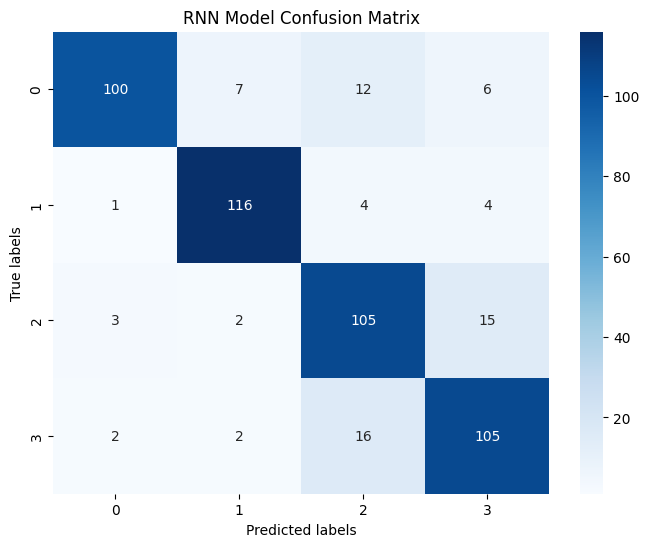

Classification Report for RNN Model:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       125
           1       0.91      0.93      0.92       125
           2       0.77      0.84      0.80       125
           3       0.81      0.84      0.82       125

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



In [260]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Calculate confusion matrix

cm = confusion_matrix(y_test, predictions)

# Calculate classification report
cr = classification_report(y_test, predictions)

# Plot confusion matrix
# print("Confusion Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique([predictions]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RNN Model Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report for RNN Model:")
print(cr)


In [261]:
# test_df= test_df.drop(columns=['preprocessed_text','preds'],axis=1)
df = pd.read_csv("../NLP3/test.csv")
test_df_copy = df
test_df_copy.insert(loc=3, column='preds', value=predictions)
#saving prediction into w2v_test.csv file 
test_df_copy.to_csv("rnn_test.csv")

# LSTM Model

In [262]:

class LSTMlastm_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout):
        super(LSTMlastm_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        avg_pooled = torch.mean(out,dim=1)
        droped = self.dropout(avg_pooled)
        # Decode the hidden state of the last time step
        out = self.fc(droped)
        return out

input_size = len(X_train_matrix[0][0])
hidden_size = 32
num_layers = 1
output_size = 4


In [263]:
# Create the lastm_model
lstm_model = LSTMlastm_Model(input_size, hidden_size, num_layers, output_size,dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(),lr=0.01)
# Train the lstm_model
num_epochs = 10
best_val_loss = float('inf')  # Initialize with a large value
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = lstm_model(inputs)
        # Compute the training loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate training loss for printing
        running_train_loss += loss.item()
    

    # Validation
    lstm_model.eval()  # Set lstm_model to evaluation mode
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for val_inputs, val_labels in val_dataloader:
            val_outputs = lstm_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(val_outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(val_labels.tolist())
        avg_val_loss = running_val_loss / len(val_dataloader)
        # Print average validation loss for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_train_loss/len(train_dataloader):.4f} , Validation Loss: {running_val_loss/len(val_dataloader):.4f}')
        
        # Calculate accuracy
        val_accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(lstm_model.state_dict(), 'best_model_loss_lstm.pth')
    lstm_model.train()  # Set lstm_model back to training mode

Epoch [1/10], Training Loss: 0.7175 , Validation Loss: 0.4565
Epoch [1/10], Validation Accuracy: 0.8700
Epoch [2/10], Training Loss: 0.4370 , Validation Loss: 0.3471
Epoch [2/10], Validation Accuracy: 0.8750
Epoch [3/10], Training Loss: 0.3623 , Validation Loss: 0.4144
Epoch [3/10], Validation Accuracy: 0.8650
Epoch [4/10], Training Loss: 0.2977 , Validation Loss: 0.3806
Epoch [4/10], Validation Accuracy: 0.8600
Epoch [5/10], Training Loss: 0.2503 , Validation Loss: 0.3872
Epoch [5/10], Validation Accuracy: 0.8950
Epoch [6/10], Training Loss: 0.2152 , Validation Loss: 0.4005
Epoch [6/10], Validation Accuracy: 0.8600
Epoch [7/10], Training Loss: 0.1744 , Validation Loss: 0.5616
Epoch [7/10], Validation Accuracy: 0.8700
Epoch [8/10], Training Loss: 0.1807 , Validation Loss: 0.4359
Epoch [8/10], Validation Accuracy: 0.8550
Epoch [9/10], Training Loss: 0.1255 , Validation Loss: 0.6065
Epoch [9/10], Validation Accuracy: 0.8450
Epoch [10/10], Training Loss: 0.1199 , Validation Loss: 0.6275
E

In [264]:
lstm_model = LSTMlastm_Model(input_size, hidden_size, num_layers, output_size,dropout=0.5)
# Load the saved state dict
print("LSTM Model Accuracies")
lstm_model.load_state_dict(torch.load('best_model_loss_lstm.pth'))
lstm_model.eval()  # Set lstm_model to evaluation mode
with torch.no_grad():
    outputs = lstm_model(X_train_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_train).float().mean()
    print(f'Training Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the lstm_model on validation data
with torch.no_grad():
    outputs = lstm_model(X_val_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_val).float().mean()
    print(f'Validation Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the lstm_model on test data
with torch.no_grad():
    outputs = lstm_model(X_test_matrix)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_test).float().mean()
    print(f'Testing Accuracy: {accuracy.item()*100:.2f}%')

LSTM Model Accuracies
Training Accuracy: 90.17%
Validation Accuracy: 87.50%
Testing Accuracy: 85.80%


In [265]:
from sklearn.metrics import f1_score, accuracy_score
f1 = f1_score(y_test, predictions,average='micro')
print("F1 score for LSTM Model:", f1)

F1 score for LSTM Model: 0.858


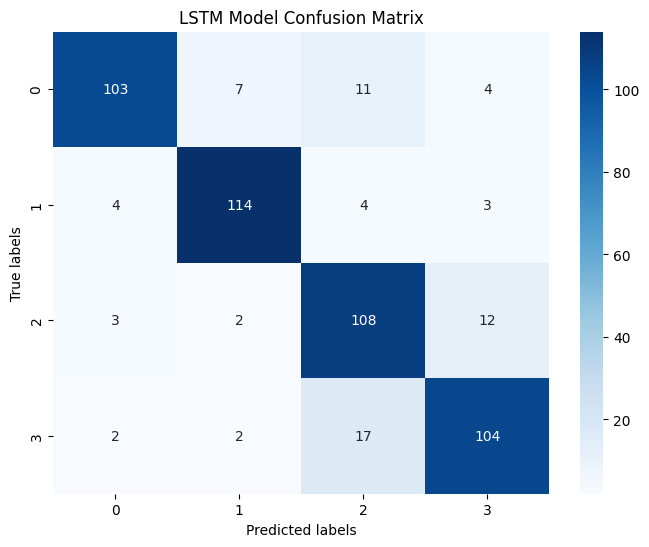

Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       125
           1       0.91      0.91      0.91       125
           2       0.77      0.86      0.82       125
           3       0.85      0.83      0.84       125

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [266]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculate classification report
cr = classification_report(y_test, predictions)

# Plot confusion matrix
# print("Confusion Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique([predictions]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LSTM Model Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report for LSTM Model:")
print(cr)


In [267]:
# test_df= test_df.drop(columns=['preprocessed_text','preds'],axis=1)
df = pd.read_csv("../NLP3/test.csv")
test_df_copy = df
test_df_copy.insert(loc=3, column='preds', value=predictions)
#saving prediction into w2v_test.csv file 
test_df_copy.to_csv("lstm_test.csv")